In [1]:
import pandas as pd
import qgrid
from collections import Counter
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import scipy
from scipy import io
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
data = pd.read_csv('cooking.csv')

In [4]:
data

,id,title,content,tags
0,1,How can I get chewy chocolate chip cookies?,<p>My chocolate chips cookies are always too c...,baking cookies texture
1,2,How should I cook bacon in an oven?,<p>I've heard of people cooking bacon in an ov...,oven cooking-time bacon
2,3,What is the difference between white and brown...,"<p>I always use brown extra large eggs, but I ...",eggs
3,4,What is the difference between baking soda and...,<p>And can I use one in place of the other in ...,substitutions please-remove-this-tag baking-so...
4,5,"In a tomato sauce recipe, how can I cut the ac...",<p>It seems that every time I make a tomato sa...,sauce pasta tomatoes italian-cuisine
5,6,What ingredients (available in specific region...,<p>I have a recipe that calls for fresh parsle...,substitutions herbs parsley
6,9,What is the internal temperature a steak shoul...,<p>I'd like to know when to take my steaks off...,food-safety beef cooking-time
7,11,How should I poach an egg?,<p>What's the best method to poach an egg with...,eggs basics poaching
8,12,"How can I make my Ice Cream ""creamier""",<p>My ice cream doesn't feel creamy enough. I...,ice-cream
9,17,How long and at what temperature do the variou...,"<p>I'm interested in baking thighs, legs, brea...",baking chicken cooking-time


In [60]:
tags = data['tags'].values
tags_list = []
for item in tags:
    tags_list.extend(item.split())
c = Counter(tags_list)
used_tags = dict(c.most_common(5)).keys()

In [61]:
filtered = pd.DataFrame(columns=used_tags)
rows = 0
for key in used_tags:
    df = data[data['tags'].str.contains(key)]
    print("DataFrame with key %s has %d rows" % (key, df.shape[0]))
    rows += df.shape[0]
    filtered = filtered.append(df)
    
# Dropping duplicated indices (more than one tag)
filtered.drop_duplicates(inplace=True)
print("Total rows %d != %d df shape. %d rows were duplicated." %(rows, filtered.shape[0], rows-filtered.shape[0]))

DataFrame with key bread has 746 rows
DataFrame with key baking has 1480 rows
DataFrame with key food-safety has 1211 rows
DataFrame with key substitutions has 920 rows
DataFrame with key equipment has 816 rows
Total rows 5173 != 4647 df shape. 526 rows were duplicated.


In [62]:
filtered['class'] = 0
for idx, key in enumerate(used_tags):
    filtered.loc[~filtered['tags'].str.contains(key), key] = 0
    filtered.loc[filtered['tags'].str.contains(key), key] = 1
    filtered.loc[filtered['tags'].str.contains(key), 'class'] += 2**idx

In [63]:
single_filter = pd.DataFrame(columns=['class_label'])
for idx, key in enumerate(used_tags):
    filtered.loc[filtered['class'] == 2**idx, 'class_label'] = key
    df = filtered[filtered['class'] == 2**idx]
    single_filter = single_filter.append(df)

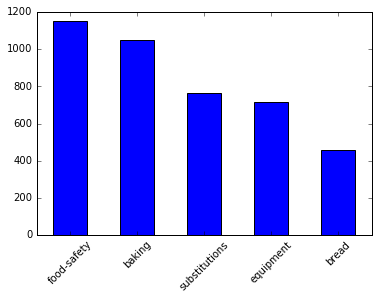

In [64]:
fig = plt.figure()
single_filter['class_label'].value_counts().plot(kind='bar', rot=45)
plt.show()

In [65]:
single_filter.columns

Index(['baking', 'bread', 'class', 'class_label', 'content', 'equipment',
       'food-safety', 'id', 'substitutions', 'tags', 'title'],
      dtype='object')

In [66]:
data2 = single_filter.drop(['baking', 'bread', 'class_label', 'equipment', 'food-safety', 'id', 'substitutions', 'tags'], axis=1)

In [67]:
def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    return text

def review_to_words( raw_review, stops ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    #stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))   

stopword_list = stopwords.words('english')
with open('en.txt', 'r') as pt_file:
    st_list_txt = pt_file.read()
stopword_list.extend(st_list_txt.split())
content = data2['content'].apply(remove_html)
data2['content'] = content
content = data2['content'].apply(review_to_words, stops=stopword_list)
data2['content'] = content
content = data2['title'].apply(review_to_words, stops=stopword_list)
data2['title'] = content
data2 = data2.reset_index()

In [69]:
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 300) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(data2['content'])

# Numpy arrays are easy to work with, so convert the result to an 
# array
train_data_features = train_data_features.toarray()

In [70]:
# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names()
vocab_cell = np.asarray(vocab).astype(object)

In [71]:
data_array = np.empty((len(data2['class'].unique()), 1), dtype=object)
for i, item in enumerate(data2['class'].unique()):
    idx = data2[data2['class'] == item].index.tolist()
    print("Train set with class %d has %d observations." %(item, len(idx)))
    train = train_data_features[idx]
    to_remove = np.where(~train.any(axis=1))[0]
    train = np.array([np.delete(train, to_remove, 0)]).astype(np.double)
    print("%d obs were removed. Total: %d" %(len(to_remove), len(train[0])))
    data_array[i] = [train[0]]

Train set with class 1 has 459 observations.
0 obs were removed. Total: 459
Train set with class 2 has 1048 observations.
0 obs were removed. Total: 1048
Train set with class 4 has 1150 observations.
1 obs were removed. Total: 1149
Train set with class 8 has 763 observations.
4 obs were removed. Total: 759
Train set with class 16 has 716 observations.
5 obs were removed. Total: 711


In [72]:
io.savemat('cooking.mat', mdict={'train_set': data_array.T, 'marc_label': vocab_cell})